In [5]:
%load_ext autoreload
%autoreload 2

import os, glob, re
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Analysis of the Bamberg sample from Miriam Kunz

## Goal of this document

In this document I collect the results of study and work I have done over the year 2018. This document describes my work on the Bamberg videos from Miriam Kunz. 

## The Bamberg sample and labeling

The bamberg sample consists out of 40 videos of roughly 10 minutes. The video focusses on the face of different people who get about 10 pain stimuli during the ten minutes. The people are idle and do not speak.
The videos have been annotted by trained FACS encoders. The encoders have only encoded X seconds after a pain stimuli has been given. When the pain stimuli is given can be determined from the file with FACS labels. 
Information on and examples of FACS encoding:
- https://en.wikipedia.org/wiki/Facial_Action_Coding_System
- https://www.cs.cmu.edu/~face/facs.htm
- https://imotions.com/blog/facial-action-coding-system/

## Openface

For the face expression analysis I used the openface package (https://github.com/TadasBaltrusaitis/OpenFace/wiki). Among other things, openface outputs csv files with action unit (AU) detections (both dicrete (c) and intensity (r)). The openface output is a timeseries.  

Lets get the openface outputs here:

In [14]:
# For me the openface output is stored here:
openface_output_dir = os.path.join("G:","PROJECT_DATA","DEMENTIA_2017","BAMBERG_ANALYSIS",
                                     "v2_start_Dec2018_OpenFace_2.0.5_win_x64","openface_output")
# Get all csv files
files = glob.glob(os.path.join(openface_output_dir, "*.csv"))
# Find the code in the filename that identifies the video
re_expr = re.compile(r"(\d\d\d)_...csv")
codes = [re.match(re_expr, os.path.basename(f)).group(1) for f in files]
# Store both code and file path in a dictionairy
openface_output = {c:f for c, f in zip(codes, files)}

del(files, codes, openface_output_dir)

{}

Lets take the first openface output file and read it into a pandas dataframe. Then I show the start of the table to show the structure of the output file.

In [13]:
of_example = pd.read_csv(next(iter(openface_output.values())), skipinitialspace=True)
of_example.head()

StopIteration: 

We can plot the action unit nr 12 (Lip corner puller) as an example. It also shows the difference between the discrete detection of openface (c) and the intensity detections (r).

In [7]:
of_example.plot(x="timestamp", y=["AU12_c", "AU12_r"], figsize=(15,10), subplots=True, sharex=True)

NameError: name 'of_example' is not defined

## FACS label file conversion

The FACS encoded data is stored in a different format and we need to convert it.
Lets read in the file and inspect its format:

In [59]:
FACS_dir = os.path.join("G:\\","PROJECT_DATA","DEMENTIA_2017","BAMBERG","FACS_encoding","original")
# Get all the files with a glob
files = glob.glob(os.path.join(FACS_dir, "*.xlsx"), recursive=True)
# Find the code in the filename that identifies the video
re_expr = re.compile(r".*(\d\d\d)_vl.*")
codes = [re.match(re_expr, os.path.basename(f)).group(1) for f in files]
# Store both code and file path in a dictionairy
FACS_files = {c:f for c, f in zip(codes, files)}

del(files, codes, FACS_dir)

In [65]:
facs_example = pd.read_excel(next(iter(FACS_files.values())), skipinitialspace=True)
facs_example.head()

,Date_Time_Absolute_dmy_hmsf,Date_dmy,Time_Absolute_hms,Time_Absolute_f,Time_Relative_hmsf,Time_Relative_hms,Time_Relative_f,Time_Relative_sf,Duration_sf,Observation,Event_Log,Behavior,Modifier_1,Event_Type
0,2010-10-22 14:08:56.390,2010-10-22 14:08:56.390,2010-10-22 14:08:56,390,00:00:26.475000,00:00:26,475,26.4749,0.00000,003_vl,Event log0001,heat_start,NaN,State point
1,2010-10-22 14:09:24.112,2010-10-22 14:09:24.112,2010-10-22 14:09:24,112,00:00:54.197000,00:00:54,197,54.1966,0.00000,003_vl,Event log0001,pain_start,NaN,State point
2,2010-10-22 14:09:25.129,2010-10-22 14:09:25.129,2010-10-22 14:09:25,129,00:00:55.214000,00:00:55,214,55.2144,4.52675,003_vl,Event log0001,12_p_vl,2.0,State start
3,2010-10-22 14:09:25.163,2010-10-22 14:09:25.163,2010-10-22 14:09:25,163,00:00:55.248000,00:00:55,248,55.2478,4.49339,003_vl,Event log0001,06_p_vl,2.0,State start
4,2010-10-22 14:09:25.163,2010-10-22 14:09:25.163,2010-10-22 14:09:25,163,00:00:55.248000,00:00:55,248,55.2478,4.49339,003_vl,Event log0001,07_p_vl,2.0,State start


### Conversion steop 1 for FACS labels 

The labeling of the FACS data is saved in a way that we want to change. Per row in the FACS excel file is a start or stop ("Time_Relative_sf") of a "Behaviour". This behaviour is a feature like an AU or the start or stop of a pain stimuli ("pain_start"). For AUs you can also have a "Modifier_1" which is the intensity with which the annotator rated the AU. In the next function I convert this file to a format of periods. In this format one row is one occurance of an AU (or pain start), so every row has a start and stop time, a behaviour and an intensity.

In [22]:
dummy_df = pd.DataFrame({"Time_Relative_sf": [1, 2, 2, 5, 1], "Duration_sf":[0.01, 0.02, 2, 5, 1],\
                         "Behavior" : ["AU01", "AU01", "AU02", "AU02", "pain start"], \
                         "Event_Type": ["State start", "State stop", "State start", "State stop", "State point"], \
                         "Modifier_1": [3, 3, 2, 2, 0]})

facs_example = dummy_df

In [65]:
import conversions
timeseries = conversions.convert_bamberg_to_timeseries(
    dataframe=facs_example, 
    time_line = [0,1,2,3,4, 5, 6, 7],
    pain_duration=1,
    results_col_name_for_feature="feature"
)
facs_example_conv.head()
timeseries.head()

,time,AU01,AU02,pain start
0,0,0,0,0
1,1,3,0,1
2,2,3,2,1
3,3,0,2,0
4,4,0,2,0


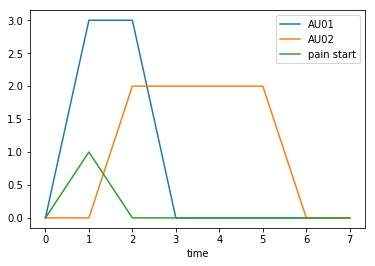

In [61]:
timeseries.plot(x="time")

In [ ]:
def merge_openface_facs(of_dateframe, facs_dataframe):
    